# Fit VNA resonances at different power outputs

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import os
from iminuit.cost import LeastSquares

from irdetection.analysis.fitting.FitAPI import Fitter
from irdetection.analysis.fitting.searcher import ResonancePeakSearcher
import irdetection.analysis.fitting.models as md

In [2]:
def read_peaks_data(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    with h5py.File(filename, 'r') as hf:
        for pk in range(1,5):
            group_name = f"peak_{pk}"
            for pw in range(-45, 0, 5):
                dataset_name = f"peak_{pk}_{pw}_dBm"
                dataset_path = f"{group_name}/{dataset_name}"
                if dataset_path in hf:
                    dataset = hf[dataset_path][()]
                    data_dict[(pk, pw)] = dataset
                    metadata_dict[(pk, pw)] = {}
                    for attr in hf[dataset_path].attrs:
                        metadata_dict[(pk, pw)][attr] = hf[dataset_path].attrs[attr]
                else:
                    print(f"Dataset {dataset_path} not found in the HDF5 file")

    return data_dict, metadata_dict

In [3]:
data_all, meta_all = read_peaks_data('../Experiments/ResonatorsExperiment/run-5/data/peaks_data.h5')

# Extract data and metadata for all peaks at -45 dBm
data = {k: v for k, v in data_all.items() if k[1] == -45}
meta = {k: v for k, v in meta_all.items() if k[1] == -45}

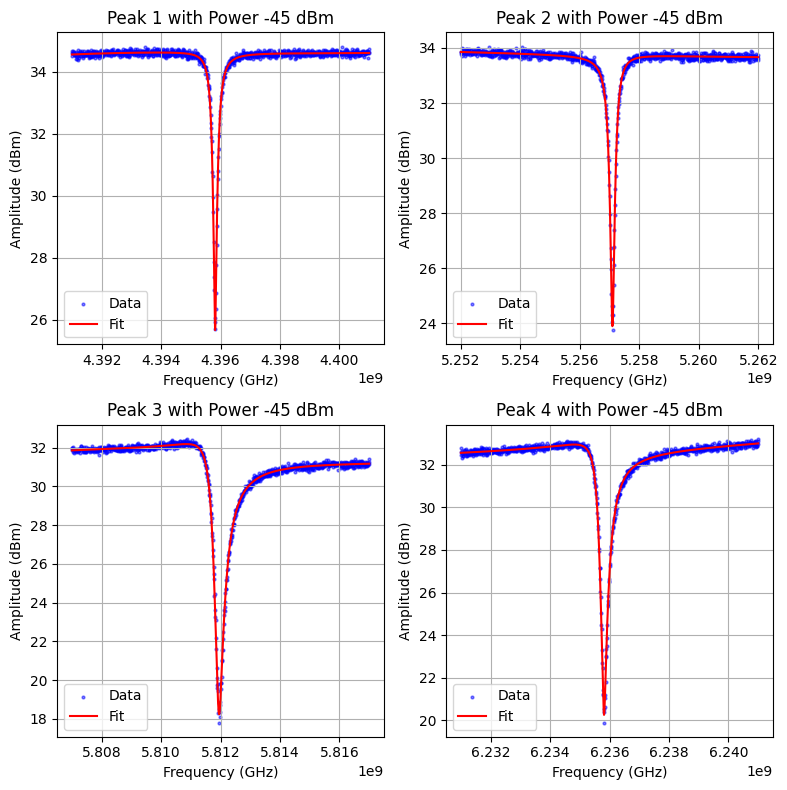

In [7]:
resonance_frequneces = []

nof_peaks = 4
fig, ax = plt.subplots(int(np.sqrt(nof_peaks)), int(np.sqrt(nof_peaks)), figsize=(8, 8))
row_iter = 0
col_iter = 0

for k, peak_data in data.items():
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]

    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T

    # try to fit
    model = md.resonance_model
    fitter = Fitter(model_function=md.resonance_model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher()
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for peak {k[0]}, power {k[1]} dBm failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            # Plot the fit result
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
            ax[row_iter, col_iter].plot(peak_data[:, 0], model(peak_data[:, 0], *fitted_params.values()), label='Fit', color='red')
            # add labels, title and legend
            ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
            ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
            ax[row_iter, col_iter].set_title(f'Peak {k[0]} with Power {k[1]} dBm')
            ax[row_iter, col_iter].legend()
            ax[row_iter, col_iter].grid()
    else:
        print(f"Fit for peak {k[0]}, power {k[1]} dBm failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        # Plot anyway the data
        ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
        # add labels, title and legend
        ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
        ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
        ax[row_iter, col_iter].set_title(f'Peak {k[0]} with Power {k[1]} dBm')
        ax[row_iter, col_iter].legend()
        ax[row_iter, col_iter].grid()

    # update iterators
    col_iter += 1
    if col_iter >= int(np.sqrt(nof_peaks)):
        col_iter = 0
        row_iter += 1

# adjust the layout
plt.tight_layout()
plt.show()